# Import Python Packages

In [32]:
import os #used to load files
import sys
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from scipy.io import loadmat #to load matlab files which are in mat format

# Import Pyod Packages & the methods

In [33]:
#this all are for models
from pyod.models.pca import PCA
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.lof import LOF
from pyod.models.cblof import CBLOF
from pyod.models.knn import KNN
from pyod.models.hbos import HBOS
from pyod.models.abod import ABOD
from pyod.models.iforest import IForest
from pyod.models.feature_bagging import FeatureBagging

# Import Metrics Packages

In [34]:
from pyod.utils.utility import standardizer
from pyod.utils.utility import precision_n_scores #measure to identify the performance of the model
from sklearn.metrics import roc_auc_score

# Define data file and read X and y

In [35]:
mat_file_list = ['arrhythmia.mat',
                 'cardio.mat',
                 'glass.mat',
                 'ionosphere.mat',
                 'letter.mat',
                 'lympho.mat',
                 'mnist.mat',
                 'musk.mat',
                 'optdigits.mat',
                 'pendigits.mat',
                 'pima.mat',
                 'satellite.mat',
                 'satimage-2.mat',
                 'shuttle.mat',
                 'vertebral.mat',
                 'vowels.mat',
                 'wbc.mat']

In [36]:
mat_file_list

['arrhythmia.mat',
 'cardio.mat',
 'glass.mat',
 'ionosphere.mat',
 'letter.mat',
 'lympho.mat',
 'mnist.mat',
 'musk.mat',
 'optdigits.mat',
 'pendigits.mat',
 'pima.mat',
 'satellite.mat',
 'satimage-2.mat',
 'shuttle.mat',
 'vertebral.mat',
 'vowels.mat',
 'wbc.mat']

# How to load Mat File 

In [37]:
from scipy.io import loadmat

In [39]:
data=loadmat('cardio.mat')

In [40]:
data

{'__header__': b'MATLAB 5.0 MAT-file, written by Octave 3.8.0, 2014-12-18 10:48:09 UTC',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[ 0.00491231,  0.69319077, -0.20364049, ...,  0.23149795,
         -0.28978574, -0.49329397],
        [ 0.11072935, -0.07990259, -0.20364049, ...,  0.09356344,
         -0.25638541, -0.49329397],
        [ 0.21654639, -0.27244466, -0.20364049, ...,  0.02459619,
         -0.25638541,  1.14001753],
        ...,
        [-0.41835583, -0.91998844, -0.16463485, ..., -1.49268341,
          0.24461959, -0.49329397],
        [-0.41835583, -0.91998844, -0.15093411, ..., -1.42371616,
          0.14441859, -0.49329397],
        [-0.41835583, -0.91998844, -0.20364049, ..., -1.28578165,
          3.58465295, -0.49329397]]),
 'y': array([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])}

In [41]:
len(data)

5

In [42]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [43]:
data.values()

dict_values([b'MATLAB 5.0 MAT-file, written by Octave 3.8.0, 2014-12-18 10:48:09 UTC', '1.0', [], array([[ 0.00491231,  0.69319077, -0.20364049, ...,  0.23149795,
        -0.28978574, -0.49329397],
       [ 0.11072935, -0.07990259, -0.20364049, ...,  0.09356344,
        -0.25638541, -0.49329397],
       [ 0.21654639, -0.27244466, -0.20364049, ...,  0.02459619,
        -0.25638541,  1.14001753],
       ...,
       [-0.41835583, -0.91998844, -0.16463485, ..., -1.49268341,
         0.24461959, -0.49329397],
       [-0.41835583, -0.91998844, -0.15093411, ..., -1.42371616,
         0.14441859, -0.49329397],
       [-0.41835583, -0.91998844, -0.20364049, ..., -1.28578165,
         3.58465295, -0.49329397]]), array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]])])

# Input(Independent) Feature Shape in Mat file format

In [44]:
type(data['X']),data['X'].shape  #number of rows and columns

(numpy.ndarray, (1831, 21))

# Dependent/ Target /Output Feature shape

In [45]:
type(data['y']),data['y'].shape

(numpy.ndarray, (1831, 1))

In [46]:
#list of all algorithms
df_columns = ['Data', '#Samples', '# Dimensions', 'Outlier Perc',
              'ABOD', 'CBLOF', 'FB', 'HBOS', 'IForest', 'KNN', 'LOF', 'MCD',
              'OCSVM', 'PCA']

In [47]:
roc_df = pd.DataFrame(columns=df_columns) #ROC Performance evolution table... roc(region of charastics)

In [48]:
prn_df = pd.DataFrame(columns=df_columns)  #Precision_n_Score Performance evolution table

In [49]:
time_df = pd.DataFrame(columns=df_columns) #time dataframe

# Exploraing All Mat files

In [50]:
from time import time
random_state = np.random.RandomState(42)

for mat_file in mat_file_list:
    print("\n... Processing", mat_file, '...')
    mat = loadmat(os.path.join( mat_file))

    X = mat['X']
    y = mat['y'].ravel()
    outliers_fraction = np.count_nonzero(y) / len(y)
    outliers_percentage = round(outliers_fraction * 100, ndigits=4)

    # construct containers for saving results
    roc_list = [mat_file[:-4], X.shape[0], X.shape[1], outliers_percentage] #:-4 is from starting till -4
    prn_list = [mat_file[:-4], X.shape[0], X.shape[1], outliers_percentage]
    time_list = [mat_file[:-4], X.shape[0], X.shape[1], outliers_percentage]

    # 60% data for training and 40% for testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                        random_state=random_state)

    # standardizing data for processing
    X_train_norm, X_test_norm = standardizer(X_train, X_test)  #norm is normalisation

    classifiers = {'Angle-based Outlier Detector (ABOD)': ABOD(  #creatin classifiers in dictonary
        contamination=outliers_fraction), #contamination is a method which detcts outliers
        'Cluster-based Local Outlier Factor': CBLOF(
            contamination=outliers_fraction, check_estimator=False,
            random_state=random_state),
        'Feature Bagging': FeatureBagging(contamination=outliers_fraction,
                                          random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(
            contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,
                                    random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Local Outlier Factor (LOF)': LOF(
            contamination=outliers_fraction),
        'Minimum Covariance Determinant (MCD)': MCD(
            contamination=outliers_fraction, random_state=random_state),
        'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
        'Principal Component Analysis (PCA)': PCA(
            contamination=outliers_fraction, random_state=random_state),
    }

    for clf_name, clf in classifiers.items():
        t0 = time()  #starting time of training
        clf.fit(X_train_norm)  #training model
        test_scores = clf.decision_function(X_test_norm) #gives the scores
        t1 = time() #training completed
        duration = round(t1 - t0, ndigits=4) #time complest - when it starts
        time_list.append(duration) 

        roc = round(roc_auc_score(y_test, test_scores), ndigits=4) #roc_auc_score gives the roc 
        prn = round(precision_n_scores(y_test, test_scores), ndigits=4)

        print('{clf_name} ROC:{roc}, precision @ rank n:{prn}, '
              'execution time: {duration}s'.format(
            clf_name=clf_name, roc=roc, prn=prn, duration=duration))

        roc_list.append(roc) #addes roc score in list
        prn_list.append(prn)

    temp_df = pd.DataFrame(time_list).transpose()
    temp_df.columns = df_columns
    time_df = pd.concat([time_df, temp_df], axis=0)

    temp_df = pd.DataFrame(roc_list).transpose()
    temp_df.columns = df_columns
    roc_df = pd.concat([roc_df, temp_df], axis=0)

    temp_df = pd.DataFrame(prn_list).transpose()
    temp_df.columns = df_columns
    prn_df = pd.concat([prn_df, temp_df], axis=0)


... Processing arrhythmia.mat ...
Angle-based Outlier Detector (ABOD) ROC:0.7687, precision @ rank n:0.3571, execution time: 1.4016s
Cluster-based Local Outlier Factor ROC:0.7684, precision @ rank n:0.4643, execution time: 1.719s
Feature Bagging ROC:0.7799, precision @ rank n:0.5, execution time: 0.5092s
Histogram-base Outlier Detection (HBOS) ROC:0.8511, precision @ rank n:0.5714, execution time: 1.8122s
Isolation Forest ROC:0.8527, precision @ rank n:0.5714, execution time: 0.6705s
K Nearest Neighbors (KNN) ROC:0.782, precision @ rank n:0.5, execution time: 0.0871s
Local Outlier Factor (LOF) ROC:0.7787, precision @ rank n:0.4643, execution time: 0.0627s


/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


Minimum Covariance Determinant (MCD) ROC:0.8228, precision @ rank n:0.4286, execution time: 0.8378s
One-class SVM (OCSVM) ROC:0.7986, precision @ rank n:0.5, execution time: 0.056s
Principal Component Analysis (PCA) ROC:0.7997, precision @ rank n:0.5, execution time: 0.0728s

... Processing cardio.mat ...
Angle-based Outlier Detector (ABOD) ROC:0.5763, precision @ rank n:0.1875, execution time: 0.6293s
Cluster-based Local Outlier Factor ROC:0.8221, precision @ rank n:0.4844, execution time: 0.3565s
Feature Bagging ROC:0.4879, precision @ rank n:0.1406, execution time: 0.7313s
Histogram-base Outlier Detection (HBOS) ROC:0.8453, precision @ rank n:0.4688, execution time: 0.0094s
Isolation Forest ROC:0.9414, precision @ rank n:0.5, execution time: 0.4715s
K Nearest Neighbors (KNN) ROC:0.6959, precision @ rank n:0.2812, execution time: 0.159s
Local Outlier Factor (LOF) ROC:0.4715, precision @ rank n:0.125, execution time: 0.0999s


/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-152.076751858648862 > -250.756822706501453). You may want to try with a higher value of support_fraction (current value: 0.511).
  RuntimeWarning)


Minimum Covariance Determinant (MCD) ROC:0.8778, precision @ rank n:0.3906, execution time: 0.6343s
One-class SVM (OCSVM) ROC:0.9507, precision @ rank n:0.5938, execution time: 0.0794s
Principal Component Analysis (PCA) ROC:0.9638, precision @ rank n:0.6875, execution time: 0.006s

... Processing glass.mat ...
Angle-based Outlier Detector (ABOD) ROC:0.7104, precision @ rank n:0.25, execution time: 0.051s
Cluster-based Local Outlier Factor ROC:0.8506, precision @ rank n:0.25, execution time: 0.0647s
Feature Bagging ROC:0.7043, precision @ rank n:0.25, execution time: 0.0554s
Histogram-base Outlier Detection (HBOS) ROC:0.6524, precision @ rank n:0.0, execution time: 0.0048s
Isolation Forest ROC:0.7195, precision @ rank n:0.25, execution time: 0.3573s
K Nearest Neighbors (KNN) ROC:0.7805, precision @ rank n:0.25, execution time: 0.0098s
Local Outlier Factor (LOF) ROC:0.7774, precision @ rank n:0.25, execution time: 0.0035s
Minimum Covariance Determinant (MCD) ROC:0.7165, precision @ rank 

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-303.881944356529402 > -525.830836350540153). You may want to try with a higher value of support_fraction (current value: 0.614).
  RuntimeWarning)
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-304.021763033307082 > -523.143378896311901). You may want to try with a higher value of support_fraction (current value: 0.614).
  RuntimeWarning)
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-338.921775030610604 > -381.672782741425522). You may want to try with a higher value of support_fraction (cur

Angle-based Outlier Detector (ABOD) ROC:0.7813, precision @ rank n:0.3562, execution time: 6.9056s
Cluster-based Local Outlier Factor ROC:0.8447, precision @ rank n:0.4007, execution time: 1.0376s
Feature Bagging ROC:0.7259, precision @ rank n:0.3664, execution time: 47.7027s
Histogram-base Outlier Detection (HBOS) ROC:0.5675, precision @ rank n:0.1199, execution time: 0.0747s
Isolation Forest ROC:0.7801, precision @ rank n:0.2979, execution time: 1.9798s
K Nearest Neighbors (KNN) ROC:0.8409, precision @ rank n:0.4144, execution time: 7.0826s
Local Outlier Factor (LOF) ROC:0.7085, precision @ rank n:0.339, execution time: 5.6531s


/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


Minimum Covariance Determinant (MCD) ROC:0.863, precision @ rank n:0.3973, execution time: 2.4416s
One-class SVM (OCSVM) ROC:0.8417, precision @ rank n:0.3801, execution time: 4.4025s
Principal Component Analysis (PCA) ROC:0.8396, precision @ rank n:0.3767, execution time: 0.1503s

... Processing musk.mat ...
Angle-based Outlier Detector (ABOD) ROC:0.0809, precision @ rank n:0.0333, execution time: 2.2614s
Cluster-based Local Outlier Factor ROC:1.0, precision @ rank n:1.0, execution time: 0.3556s
Feature Bagging ROC:0.5228, precision @ rank n:0.1667, execution time: 11.9681s
Histogram-base Outlier Detection (HBOS) ROC:0.9999, precision @ rank n:0.9667, execution time: 0.0773s
Isolation Forest ROC:0.9996, precision @ rank n:0.9333, execution time: 1.0946s
K Nearest Neighbors (KNN) ROC:0.7348, precision @ rank n:0.2333, execution time: 1.7547s
Local Outlier Factor (LOF) ROC:0.5323, precision @ rank n:0.1333, execution time: 1.5163s
Minimum Covariance Determinant (MCD) ROC:1.0, precision 

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


Minimum Covariance Determinant (MCD) ROC:0.3486, precision @ rank n:0.0, execution time: 1.2116s
One-class SVM (OCSVM) ROC:0.4972, precision @ rank n:0.0, execution time: 1.3224s
Principal Component Analysis (PCA) ROC:0.504, precision @ rank n:0.0, execution time: 0.0424s

... Processing pendigits.mat ...
Angle-based Outlier Detector (ABOD) ROC:0.7008, precision @ rank n:0.0308, execution time: 1.8598s
Cluster-based Local Outlier Factor ROC:0.9609, precision @ rank n:0.3077, execution time: 0.3102s
Feature Bagging ROC:0.4687, precision @ rank n:0.0462, execution time: 4.0759s
Histogram-base Outlier Detection (HBOS) ROC:0.9294, precision @ rank n:0.2615, execution time: 0.0118s
Isolation Forest ROC:0.9422, precision @ rank n:0.2769, execution time: 0.7676s
K Nearest Neighbors (KNN) ROC:0.7602, precision @ rank n:0.0462, execution time: 0.5868s
Local Outlier Factor (LOF) ROC:0.481, precision @ rank n:0.0462, execution time: 0.5134s
Minimum Covariance Determinant (MCD) ROC:0.8271, precisi

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-49.541490230701029 > -75.592253998160075). You may want to try with a higher value of support_fraction (current value: 0.503).
  RuntimeWarning)
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-50.022992269210960 > -76.150022952275933). You may want to try with a higher value of support_fraction (current value: 0.503).
  RuntimeWarning)
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-48.588090860494539 > -73.997089087121466). You may want to try with a higher value of support_fraction (current v

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-50.246740593074335 > -75.373826826202034). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-50.256978425484334 > -76.476983289741668). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-50.288199308055383 > -75.990589261845741). You may want to try with a higher value of support_fraction (current v

Minimum Covariance Determinant (MCD) ROC:0.9903, precision @ rank n:0.7534, execution time: 12.3356s
One-class SVM (OCSVM) ROC:0.9922, precision @ rank n:0.9553, execution time: 49.618s
Principal Component Analysis (PCA) ROC:0.9902, precision @ rank n:0.9503, execution time: 0.0307s

... Processing vertebral.mat ...
Angle-based Outlier Detector (ABOD) ROC:0.2797, precision @ rank n:0.0, execution time: 0.0571s
Cluster-based Local Outlier Factor ROC:0.3908, precision @ rank n:0.0, execution time: 0.0623s
Feature Bagging ROC:0.3027, precision @ rank n:0.0, execution time: 0.0515s
Histogram-base Outlier Detection (HBOS) ROC:0.2695, precision @ rank n:0.0, execution time: 0.004s
Isolation Forest ROC:0.3576, precision @ rank n:0.0, execution time: 0.4381s
K Nearest Neighbors (KNN) ROC:0.318, precision @ rank n:0.0, execution time: 0.0102s
Local Outlier Factor (LOF) ROC:0.318, precision @ rank n:0.0, execution time: 0.0032s
Minimum Covariance Determinant (MCD) ROC:0.3308, precision @ rank n:

In [51]:
roc_df

,Data,#Samples,# Dimensions,Outlier Perc,ABOD,CBLOF,FB,HBOS,IForest,KNN,LOF,MCD,OCSVM,PCA
0,arrhythmia,452,274,14.6018,0.7687,0.7684,0.7799,0.8511,0.8527,0.782,0.7787,0.8228,0.7986,0.7997
0,cardio,1831,21,9.6122,0.5763,0.8221,0.4879,0.8453,0.9414,0.6959,0.4715,0.8778,0.9507,0.9638
0,glass,214,9,4.2056,0.7104,0.8506,0.7043,0.6524,0.7195,0.7805,0.7774,0.7165,0.6189,0.622
0,ionosphere,351,33,35.8974,0.9004,0.8952,0.8933,0.5195,0.8309,0.9134,0.8989,0.9399,0.8372,0.7971
0,letter,1600,32,6.25,0.8465,0.7423,0.866,0.5728,0.5778,0.845,0.8409,0.7499,0.5744,0.48
0,lympho,148,18,4.0541,0.9382,0.9709,0.9673,0.9964,0.9855,0.9636,0.9636,0.9164,0.9636,0.9818
0,mnist,7603,100,9.2069,0.7813,0.8447,0.7259,0.5675,0.7801,0.8409,0.7085,0.863,0.8417,0.8396
0,musk,3062,166,3.1679,0.0809,1,0.5228,0.9999,0.9996,0.7348,0.5323,1,1,1
0,optdigits,5216,64,2.8758,0.4428,0.7852,0.4641,0.8822,0.5764,0.3824,0.4584,0.3486,0.4972,0.504
0,pendigits,6870,16,2.2707,0.7008,0.9609,0.4687,0.9294,0.9422,0.7602,0.481,0.8271,0.93,0.9332


In [52]:
prn_df

,Data,#Samples,# Dimensions,Outlier Perc,ABOD,CBLOF,FB,HBOS,IForest,KNN,LOF,MCD,OCSVM,PCA
0,arrhythmia,452,274,14.6018,0.3571,0.4643,0.5,0.5714,0.5714,0.5,0.4643,0.4286,0.5,0.5
0,cardio,1831,21,9.6122,0.1875,0.4844,0.1406,0.4688,0.5,0.2812,0.125,0.3906,0.5938,0.6875
0,glass,214,9,4.2056,0.25,0.25,0.25,0,0.25,0.25,0.25,0,0.25,0.25
0,ionosphere,351,33,35.8974,0.8214,0.8036,0.75,0.3393,0.6607,0.8393,0.75,0.8571,0.7143,0.5893
0,letter,1600,32,6.25,0.275,0.175,0.4,0.125,0.05,0.3,0.325,0.075,0.1,0.05
0,lympho,148,18,4.0541,0.4,0.6,0.6,0.8,0.6,0.6,0.6,0.6,0.6,0.8
0,mnist,7603,100,9.2069,0.3562,0.4007,0.3664,0.1199,0.2979,0.4144,0.339,0.3973,0.3801,0.3767
0,musk,3062,166,3.1679,0.0333,1,0.1667,0.9667,0.9333,0.2333,0.1333,0.9667,1,1
0,optdigits,5216,64,2.8758,0.0161,0,0.0484,0.2581,0.0161,0,0.0484,0,0,0
0,pendigits,6870,16,2.2707,0.0308,0.3077,0.0462,0.2615,0.2769,0.0462,0.0462,0.0615,0.2923,0.3385


In [53]:
time_df

,Data,#Samples,# Dimensions,Outlier Perc,ABOD,CBLOF,FB,HBOS,IForest,KNN,LOF,MCD,OCSVM,PCA
0,arrhythmia,452,274,14.6018,1.4016,1.719,0.5092,1.8122,0.6705,0.0871,0.0627,0.8378,0.056,0.0728
0,cardio,1831,21,9.6122,0.6293,0.3565,0.7313,0.0094,0.4715,0.159,0.0999,0.6343,0.0794,0.006
0,glass,214,9,4.2056,0.051,0.0647,0.0554,0.0048,0.3573,0.0098,0.0035,0.0464,0.002,0.0032
0,ionosphere,351,33,35.8974,0.0891,0.0811,0.0712,0.0124,0.3864,0.0174,0.0072,0.0763,0.0055,0.0039
0,letter,1600,32,6.25,0.473,0.1389,0.6711,0.0131,0.4821,0.1294,0.0795,1.2441,0.077,0.0062
0,lympho,148,18,4.0541,0.0364,0.054,0.0588,0.0087,0.3647,0.01,0.0041,0.044,0.0018,0.0029
0,mnist,7603,100,9.2069,6.9056,1.0376,47.7027,0.0747,1.9798,7.0826,5.6531,2.4416,4.4025,0.1503
0,musk,3062,166,3.1679,2.2614,0.3556,11.9681,0.0773,1.0946,1.7547,1.5163,9.5834,1.1744,0.1304
0,optdigits,5216,64,2.8758,3.0989,0.4836,15.2133,0.0382,0.986,1.6314,1.41,1.2116,1.3224,0.0424
0,pendigits,6870,16,2.2707,1.8598,0.3102,4.0759,0.0118,0.7676,0.5868,0.5134,2.4047,0.946,0.0091


# Comparing all Models

In [54]:
from numpy import percentile
import matplotlib.pyplot as plt
import matplotlib.font_manager

In [55]:
# Define the number of inliers and outliers
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0]

# Compare given detectors under given settings
# Initialize the data
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.zeros(n_samples, dtype=int)
ground_truth[-n_outliers:] = 1

# initialize a set of detectors for LSCP
detector_list = [LOF(n_neighbors=5), LOF(n_neighbors=10), LOF(n_neighbors=15),
                 LOF(n_neighbors=20), LOF(n_neighbors=25), LOF(n_neighbors=30),
                 LOF(n_neighbors=35), LOF(n_neighbors=40), LOF(n_neighbors=45),
                 LOF(n_neighbors=50)]

In [56]:
xx

array([[-7.        , -6.85858586, -6.71717172, ...,  6.71717172,
         6.85858586,  7.        ],
       [-7.        , -6.85858586, -6.71717172, ...,  6.71717172,
         6.85858586,  7.        ],
       [-7.        , -6.85858586, -6.71717172, ...,  6.71717172,
         6.85858586,  7.        ],
       ...,
       [-7.        , -6.85858586, -6.71717172, ...,  6.71717172,
         6.85858586,  7.        ],
       [-7.        , -6.85858586, -6.71717172, ...,  6.71717172,
         6.85858586,  7.        ],
       [-7.        , -6.85858586, -6.71717172, ...,  6.71717172,
         6.85858586,  7.        ]])

In [57]:
yy

array([[-7.        , -7.        , -7.        , ..., -7.        ,
        -7.        , -7.        ],
       [-6.85858586, -6.85858586, -6.85858586, ..., -6.85858586,
        -6.85858586, -6.85858586],
       [-6.71717172, -6.71717172, -6.71717172, ..., -6.71717172,
        -6.71717172, -6.71717172],
       ...,
       [ 6.71717172,  6.71717172,  6.71717172, ...,  6.71717172,
         6.71717172,  6.71717172],
       [ 6.85858586,  6.85858586,  6.85858586, ...,  6.85858586,
         6.85858586,  6.85858586],
       [ 7.        ,  7.        ,  7.        , ...,  7.        ,
         7.        ,  7.        ]])

In [58]:
# Show the statics of the data
print('Number of inliers: %i' % n_inliers)
print('Number of outliers: %i' % n_outliers)
print('Ground truth shape is {shape}. Outlier are 1 and inliers are 0.\n'.format(shape=ground_truth.shape))
print(ground_truth)

Number of inliers: 150
Number of outliers: 50
Ground truth shape is (200,). Outlier are 1 and inliers are 0.

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [59]:
# Show all detectors
for i, clf in enumerate(classifiers.keys()):
    print('Model', i + 1, clf)

Model 1 Angle-based Outlier Detector (ABOD)
Model 2 Cluster-based Local Outlier Factor
Model 3 Feature Bagging
Model 4 Histogram-base Outlier Detection (HBOS)
Model 5 Isolation Forest
Model 6 K Nearest Neighbors (KNN)
Model 7 Local Outlier Factor (LOF)
Model 8 Minimum Covariance Determinant (MCD)
Model 9 One-class SVM (OCSVM)
Model 10 Principal Component Analysis (PCA)


1 fitting Angle-based Outlier Detector (ABOD)
2 fitting Cluster-based Local Outlier Factor
3 fitting Feature Bagging
4 fitting Histogram-base Outlier Detection (HBOS)
5 fitting Isolation Forest
6 fitting K Nearest Neighbors (KNN)
7 fitting Local Outlier Factor (LOF)
8 fitting Minimum Covariance Determinant (MCD)
9 fitting One-class SVM (OCSVM)
10 fitting Principal Component Analysis (PCA)


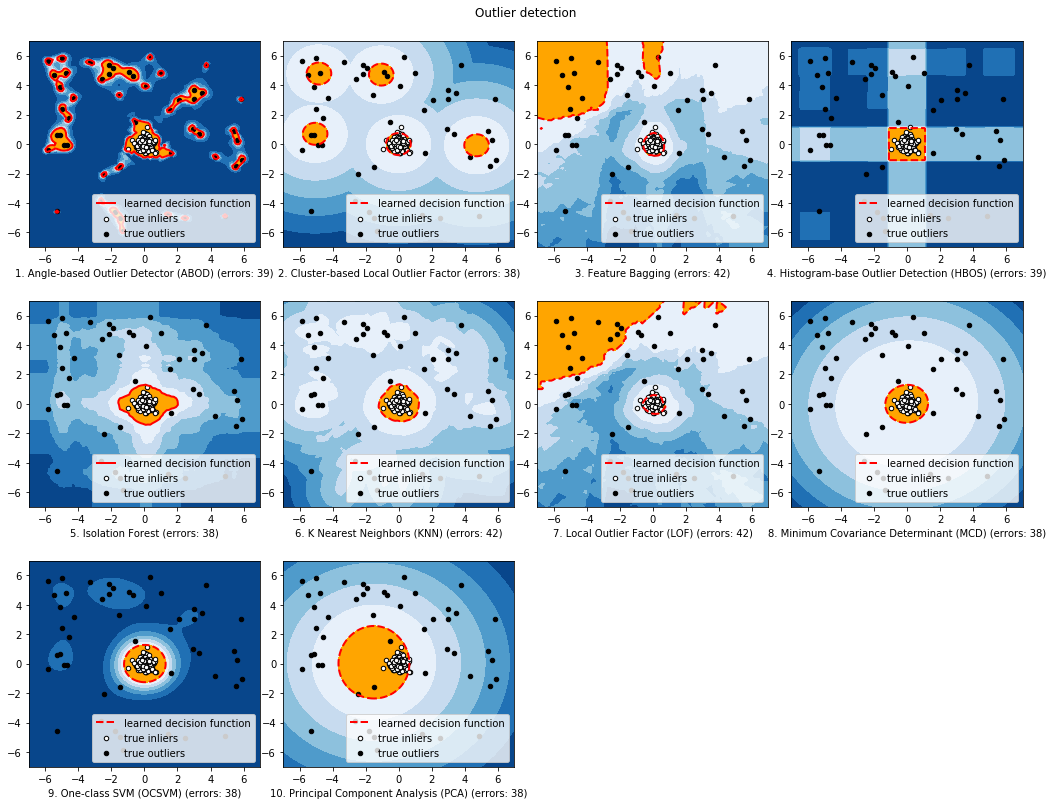

In [60]:
# Fit the models with the generated data and 
# compare model performances
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # Data generation
    X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
    X2 = 0.3 * np.random.randn(n_inliers // 2, 2) + offset
    X = np.r_[X1, X2]
    # Add outliers
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

    # Fit the model
    plt.figure(figsize=(15, 12))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        print(i + 1, 'fitting', clf_name)
        # fit the data and tag outliers
        clf.fit(X)
        scores_pred = clf.decision_function(X) * -1
        y_pred = clf.predict(X)
        threshold = percentile(scores_pred, 100 * outliers_fraction)
        n_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and the points

        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(3, 4, i + 1)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                            s=20, edgecolor='k')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                            s=20, edgecolor='k')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc='lower right')
        subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
    plt.suptitle("Outlier detection")
plt.show()